In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, Add, concatenate, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-07-03 04:56:06.602161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 04:56:06.602296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 04:56:06.727696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths to your training, validation, and testing CSV files and image folders
train_csv = '/kaggle/input/gi-track/Training.csv'
train_image_folder = '/kaggle/input/gi-track/All_Images/Training'

val_csv = '/kaggle/input/gi-track/Validation.csv'
val_image_folder = '/kaggle/input/gi-track/All_Images/Validation'

test_csv = '/kaggle/input/gi-track/Testing.csv'
test_image_folder = '/kaggle/input/gi-track/All_Images/Testing'

# Load training, validation, and testing data from CSV files
train_data = pd.read_csv(train_csv)
train_data['class'] = train_data['class'].astype(float)

val_data = pd.read_csv(val_csv)
val_data['class'] = val_data['class'].astype(float)

test_data = pd.read_csv(test_csv)
test_data['class'] = test_data['class'].astype(float)

# Get filenames and labels
train_filenames = train_data['filename'].values
train_labels = train_data['class'].values

val_filenames = val_data['filename'].values
val_labels = val_data['class'].values

test_filenames = test_data['filename'].values
test_labels = test_data['class'].values

# Function to read and preprocess image
def read_and_preprocess_image(filename, label, folder):
    img_path = tf.strings.join([folder, filename], separator='/')
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (224, 244))  # Resize images to 224x244
    img = tf.image.resize_with_pad(img, 256, 256)  # Pad images to 256x256
    img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values
    return img, tf.cast(label, tf.float32)  # Convert label to float32

# Modified function to handle missing files
def read_and_preprocess_image_safe(filename, label, folder):
    try:
        return read_and_preprocess_image(filename, label, folder)
    except tf.errors.NotFoundError:
        print(f"File {filename.numpy().decode('utf-8')} not found. Using a zero image instead.")
        zero_img = tf.zeros((256, 256, 3), dtype=tf.float32)
        return zero_img, tf.cast(label, tf.float32)

# Create TensorFlow datasets for training, validation, and testing
def create_dataset(filenames, labels, folder):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(lambda x, y: tf.py_function(read_and_preprocess_image_safe, [x, y, folder], [tf.float32, tf.float32]))
    dataset = dataset.map(lambda img, label: (tf.ensure_shape(img, (256, 256, 3)), tf.ensure_shape(label, ())))
    return dataset

train_dataset = create_dataset(train_filenames, train_labels, train_image_folder)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = create_dataset(val_filenames, val_labels, val_image_folder)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = create_dataset(test_filenames, test_labels, test_image_folder)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [3]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv4])
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv3])
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = tf.keras.layers.concatenate([up8, conv2])
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = tf.keras.layers.concatenate([up9, conv1])
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Add a GlobalAveragePooling2D layer to get a single prediction per image
    pool = tf.keras.layers.GlobalAveragePooling2D()(conv9)
    conv10 = Dense(128,activation = 'relu')(pool)
    conv10 = Dense(1,activation= 'sigmoid')(conv10)
    

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    return model

# Initialize the model
model = unet_model((256, 256, 3))
model.summary()
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,040,129 (118.41 MB)

 Trainable params: 31,040,129 (118.41 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train the model
history = model.fit(train_dataset, epochs=40, validation_data=test_dataset, callbacks=[early_stop])

Epoch 1/40


2024-07-03 04:59:57.236400: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-03 05:00:01.402251: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.165986394s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-03 05:00:05.910939: E external/

75/76 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6352 - loss: 0.6894

2024-07-03 05:05:35.625245: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,256,256]{3,2,1,0}, f32[12,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-03 05:05:36.195449: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.570282026s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,256,256]{3,2,1,0}, f32[12,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-03 05:05:38.551351: E external/

76/76 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.6327 - loss: 0.6896 - val_accuracy: 0.3858 - val_loss: 0.6955
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4362 - loss: 0.6959 - val_accuracy: 0.5547 - val_loss: 0.6923
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5501 - loss: 0.6920 - val_accuracy: 0.5202 - val_loss: 0.6918
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5500 - loss: 0.6919 - val_accuracy: 0.5758 - val_loss: 0.6897
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5631 - loss: 0.6917 - val_accuracy: 0.4683 - val_loss: 0.6888
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5365 - loss: 0.6913 - val_accuracy: 0.5202 - val_loss: 0.6833
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5433 - loss: 0.6892 - val_accuracy: 0.6008 - val_loss: 0.6747
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5820 - loss: 0.6845 - val_accuracy: 0.6372 - val_loss: 0.

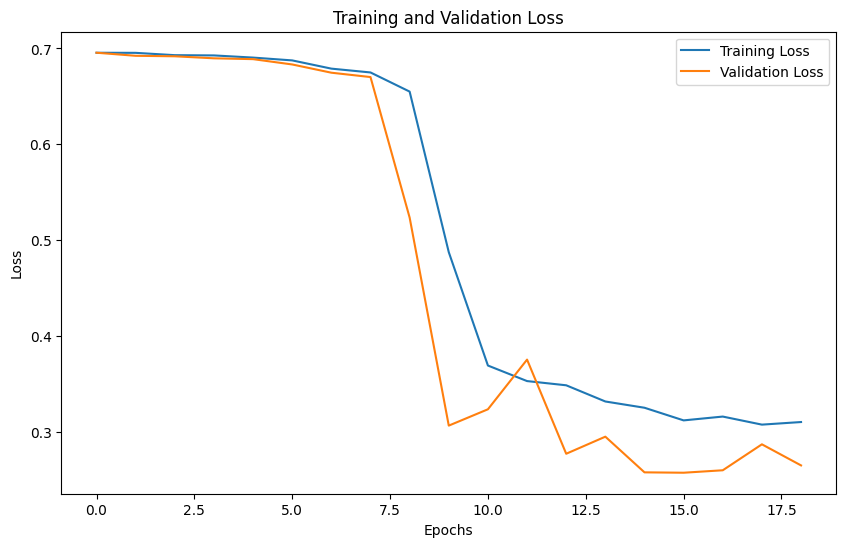

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Save the model
model.save('/kaggle/working/Unet_model_Mix.h5')

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 11s/step
Confusion Matrix:
[[ 88  21]
 [  6 129]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87       109
         1.0       0.86      0.96      0.91       135

    accuracy                           0.89       244
   macro avg       0.90      0.88      0.89       244
weighted avg       0.89      0.89      0.89       244


Class 0 - Non-Bleeding:
Sensitivity: 0.8073
Specificity: 0.9556
True Positive Rate: 0.8073
False Positive Rate: 0.0444

Class 1 - Bleeding:
Sensitivity: 0.9556
Specificity: 0.8073
True Positive Rate: 0.9556
False Positive Rate: 0.1927

ROC Curve Values:
FPR: [0.         0.         0.         0.00917431 0.00917431 0.01834862
 0.01834862 0.02752294 0.02752294 0.04587156 0.04587156 0.06422018
 0.06422018 0.0733945  0.0733945  0.08256881 0.08256881 0.09174312
 0.09174312 0.10091743 0.10091743 0.13761468 0.13761468 0.14678899
 0.14678899 0.1559633  0.1559633  0.165137

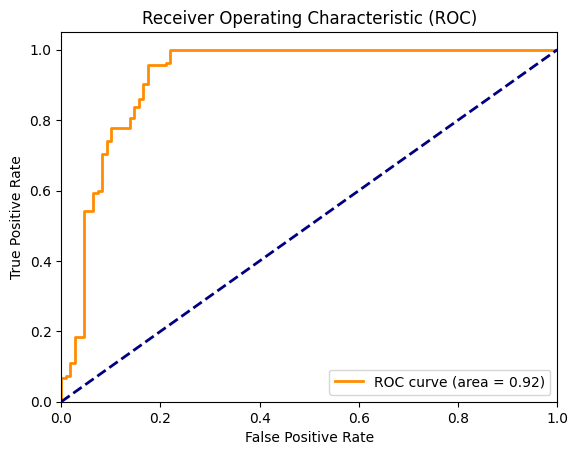

In [7]:
# Evaluate on Validation set
y_pred = model.predict(val_dataset)
y_pred_class = (y_pred > 0.5).astype(int).flatten()  # Flatten the predictions to match label shape

# Confusion Matrix
cm = confusion_matrix(val_labels, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, y_pred_class))

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(val_labels, y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 771ms/step
Confusion Matrix:
[[287  33]
 [ 16 185]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92       320
         1.0       0.85      0.92      0.88       201

    accuracy                           0.91       521
   macro avg       0.90      0.91      0.90       521
weighted avg       0.91      0.91      0.91       521


Class 0 - Non-Bleeding:
Sensitivity: 0.8969
Specificity: 0.9204
True Positive Rate: 0.8969
False Positive Rate: 0.0796

Class 1 - Bleeding:
Sensitivity: 0.9204
Specificity: 0.8969
True Positive Rate: 0.9204
False Positive Rate: 0.1031

ROC Curve Values:
FPR: [0.       0.       0.       0.003125 0.003125 0.009375 0.009375 0.0125
 0.0125   0.015625 0.015625 0.01875  0.01875  0.021875 0.021875 0.028125
 0.028125 0.028125 0.028125 0.03125  0.03125  0.03125  0.03125  0.0375
 0.0375   0.040625 0.040625 0.040625 0.040625 0.04375  0.04375  0.046875
 0.046875 0.053125

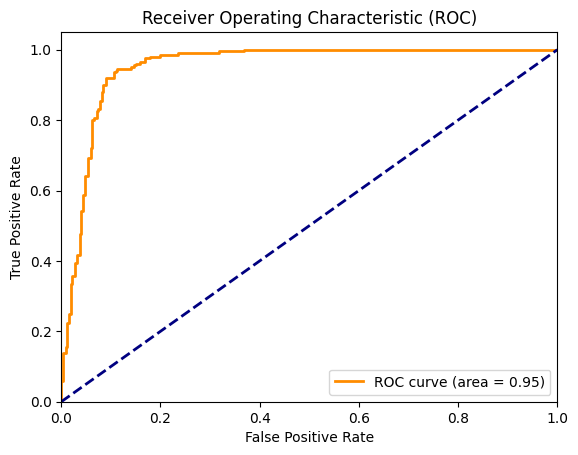

In [8]:
# Load the saved model
saved_model_path = '/kaggle/working/Unet_model_Mix.h5'  # Replace with the actual path to your saved model
model = tf.keras.models.load_model(saved_model_path)

# Evaluate on test set
y_pred = model.predict(test_dataset)
y_pred_class = (y_pred > 0.5).astype(int).flatten()  # Flatten the predictions to match label shape

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_class))

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()